# Problem Statement

#### The emotion_classification dataset has training/test subject faces with happy/sad emotion are provided in
#### the data. Each image is of 100×100 matrix. Perform PCA to reduce the dimension from
#### 10000 to K = 12. Implement a 2 hidden layer deep neural network (each layer containing
#### 10 neurons) to classify the happy/sad classes. Use the cross entropy error function with
#### softmax output activations and ReLU hidden layer activations. Perform 20 iterations of
#### back propagation and plot the error on training data as a function of the iteration. What
#### is the test accuracy for this case and how does it change if the number of hiddent neurons
#### is increased to 15. Does momentum (with a momentum factor of 0.9) improve the learning
#### process ? Provide your detailed analysis.

# Importing Libraries

In [453]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load Images

In [454]:
def load_images(folder):
    label = []
    X=[]
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        label.append(filename.split('.')[1])
        if img is not None:
            X.append(np.array(img/255.0).flatten())
            
    label = np.array(label)
    X = np.array(X)
    y = np.array([1 if 'happy' in name else 0 for name in label])

    return X,y


In [437]:
trainfolder="./emotion_classification/train"
[train_X,train_label] = load_images(trainfolder)

testfolder="./emotion_classification/test"
[test_X,test_label] = load_images(testfolder)

#  Standardizing Data

In [457]:
mean1 = train_X.mean(axis=0)
train_X = train_X - mean1

mean2 = test_X.mean(axis=0)
test_X = test_X - mean2

In [439]:
train_X.shape

(20, 10201)

In [458]:
test_X.shape

(10, 10201)

### PCA

In [440]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 12)
projected_train_x = (pca.fit_transform(train_X))
projected_test_x = pca.transform(test_X)

In [459]:
projected_train_x.shape

(20, 12)

In [460]:
projected_test_x.shape

(10, 12)

### Normalizing PCA output

In [443]:
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
projected_train_x = standard_scaler.fit_transform(projected_train_x)
projected_test_x = standard_scaler.fit_transform(projected_test_x)


In [444]:
projected_train_x.shape

(20, 12)

In [445]:
projected_test_x.shape

(10, 12)

# Multi Layer Perceptron

In [470]:
class MultiLayerPerceptron():
    def __init__(self,layers=[12,10,10,2], lr=0.0001,mf=0,iterations=20,optimizer='gradient_descent'):
        self.layers = layers
        self.lr = lr
        self.mf = mf
        self.iterations = iterations
        self.optimizer = optimizer
        self.params = {}
        self.costs = []

        
    def initialize_weights(self):
        np.random.seed(7)
        params = self.params
        layers = self.layers
        params['W1'] = np.random.randn(layers[1],layers[0]) / np.sqrt(layers[0])
        params['b1'] = np.zeros((layers[1],1))
        params['W2'] = np.random.randn(layers[2],layers[1]) / np.sqrt(layers[1])
        params['b2'] = np.zeros((layers[2],1))
        params['W3'] = np.random.randn(layers[3],layers[2]) / np.sqrt(layers[2])
        params['b3'] = np.zeros((layers[3],1))

        params['V1'] = np.zeros((layers[1],layers[0]))
        params['c1'] = np.zeros((layers[1],1))
        params['V2'] = np.zeros((layers[2],layers[1]))
        params['c2'] = np.zeros((layers[2],1))
        params['V3'] = np.zeros((layers[3],layers[2]))
        params['c3'] = np.zeros((layers[3],1))
        
    def relu(self,Z,derivative=False):
        if derivative==False:
            return np.maximum(0,Z)
        else:
            Z[Z>0]=1
            Z[Z<=0]=0
            return Z
        
    def one_hot_encode(self,y1):
        y_one_hot = np.zeros((len(y1),2))
        for i,value in enumerate(y1):
            y_one_hot[i][value] = 1

        return y_one_hot

    def softmax(self,Z):
        """Compute softmax values for each sets of scores in x."""
        e_Z = np.exp(Z - np.max(Z))
        return e_Z / e_Z.sum()
    

    def cost_function(self,y_pred,one_hot_y):
        total = one_hot_y * np.log(y_pred + 1e-8)
        return -1*(total.sum())
    
    def forward_pass(self,Z):
        params = self.params
        
        # input layer to hidden layer 1
        params['Z1'] = np.dot(params['W1'],Z) + params['b1']
        params['A1'] = self.relu(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params['W2'],params['A1']) + params['b2']
        params['A2'] = self.relu(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params['W3'],params['A2'])  + params['b3']
        params['A3'] = self.softmax(params['Z3'])
        return params['A3']
        
        
        
        
    def backward_pass(self,y_train,y_pred,Z):
        params = self.params
        
        # Calculate W3 update
        error = (y_train - y_pred)
        dcost_dw3 = np.dot(error, params['A2'].T)
        dcost_db3 = error.sum(axis=1,keepdims=True)
        
        # Calculate W2 update
        error_2 = np.multiply( np.dot(params['W3'].T, error), self.relu(params['Z2'], derivative=True) )
        dcost_dw2 = np.dot(error_2, params['A1'].T)
        dcost_db2 = error_2.sum(axis=1,keepdims=True)

        
        # Calculate W1 update
        error_3 = np.multiply( np.dot(params['W2'].T, error_2), self.relu(params['Z1'], derivative=True) )
        dcost_dw1 = np.dot(error_3, Z)
        dcost_db1 = error_3.sum(axis=1,keepdims=True)

    
        if self.optimizer == 'gradient_descent':
            change_W1 = self.lr * dcost_dw1
            change_b1 = self.lr * dcost_db1
            change_W2 = self.lr * dcost_dw2
            change_b2 = self.lr * dcost_db2
            change_W3 = self.lr * dcost_dw3
            change_b3 = self.lr * dcost_db3

        if self.optimizer == 'momentum':
            change_W1 = self.lr * dcost_dw1 + self.mf * params['V1']
            change_W2 = self.lr * dcost_dw2 + self.mf * params['V2']
            change_W3 = self.lr * dcost_dw3 + self.mf * params['V3']
            change_b1 = self.lr * dcost_db1 + self.mf * params['c1']
            change_b2 = self.lr * dcost_db2 + self.mf * params['c2']
            change_b3 = self.lr * dcost_db3 + self.mf * params['c3']
            
            params['V1'] = change_W1
            params['V2'] = change_W2
            params['V3'] = change_W3
            params['c1'] = change_b1
            params['c2'] = change_b2
            params['c3'] = change_b3
            

        params['W1'] = params['W1'] - change_W1
        params['W2'] = params['W2'] - change_W2
        params['W3'] = params['W3'] - change_W3
        params['b1'] = params['b1'] - change_b1
        params['b2'] = params['b2'] - change_b2
        params['b3'] = params['b3'] - change_b3
        

        
    def fit(self,Z,y1):
        self.initialize_weights()
        one_hot_train_y = self.one_hot_encode(y1)

        for i in range(self.iterations):
            y_pred = self.forward_pass(Z.T)
            pred1 = np.argmax(y_pred,axis=0)
            cost = self.cost_function(one_hot_train_y.T,y_pred)
            self.backward_pass(y_pred,one_hot_train_y.T,Z)
            self.costs.append(cost)

    
    def predict(self, Z, y1):
        predictions = []
        output = self.forward_pass(Z.T)
        pred = np.argmax(output,axis=0)
        return np.mean(y1==pred)

 
    def plot_cost(self,title1):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.title(title1)
        plt.show()
    
        

### Applying Gradient Descent

In [471]:
mlp = MultiLayerPerceptron()

In [472]:
mlp.fit(projected_train_x,train_label)

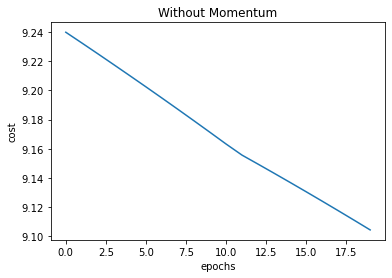

In [473]:
mlp.plot_cost('Without Momentum')

In [484]:
print("Training Accuracy without momentum : {:.2f}%".format(mlp.predict(projected_train_x,train_label)*100))

Training Accuracy without momentum : 55.00%


In [485]:
print("Testing Accuracy without momentum : {:.2f}%".format(mlp.predict(projected_test_x,test_label)*100))

Testing Accuracy without momentum : 50.00%


### Applying momentum

In [486]:
mlp_mom = MultiLayerPerceptron(mf=0.9,optimizer='momentum')

In [487]:
mlp_mom.fit(projected_train_x,train_label)

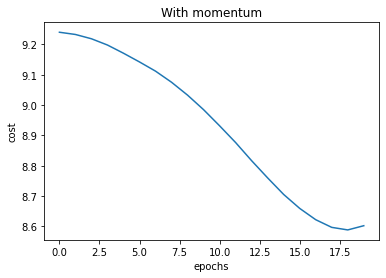

In [489]:
mlp_mom.plot_cost('With momentum')

In [490]:
print("Training Accuracy with momentum : {:.2f}%".format(mlp_mom.predict(projected_train_x,train_label)*100))

Training Accuracy with momentum : 65.00%


In [491]:
print("Testing Accuracy with momentum : {:.2f}%".format(mlp_mom.predict(projected_test_x,test_label)*100))

Testing Accuracy with momentum : 60.00%


##### Loss decreases with increase in epoch

## 15 Neurons in Hidden Layer

### Without Momentum

In [493]:
mlp_15 = MultiLayerPerceptron(layers=[12,15,15,2])

In [494]:
mlp_15.fit(projected_train_x,train_label)

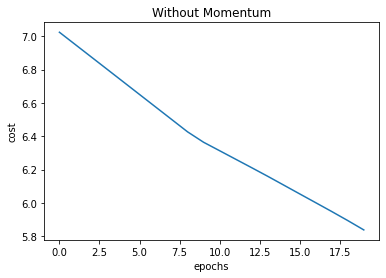

In [495]:
mlp_15.plot_cost('Without Momentum')

In [496]:
print("Training Accuracy without momentum : {:.2f}%".format(mlp_15.predict(projected_train_x,train_label)*100))

Training Accuracy without momentum : 65.00%


In [497]:
print("Testing Accuracy without momentum : {:.2f}%".format(mlp_15.predict(projected_test_x,test_label)*100))

Testing Accuracy without momentum : 40.00%


### With Momentum

In [503]:
mlp_mom_15 = MultiLayerPerceptron(layers=[12,15,15,2],mf=0.9,optimizer='momentum')

In [504]:
mlp_mom_15.fit(projected_train_x,train_label)

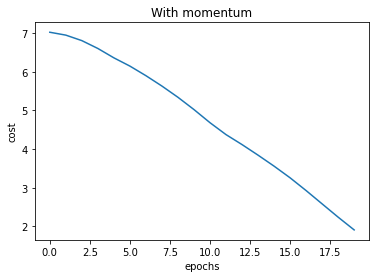

In [505]:
mlp_mom_15.plot_cost('With momentum')

In [506]:
print("Training Accuracy with momentum : {:.2f}%".format(mlp_mom_15.predict(projected_train_x,train_label)*100))

Training Accuracy with momentum : 75.00%


In [507]:
print("Testing Accuracy with momentum : {:.2f}%".format(mlp_mom_15.predict(projected_test_x,test_label)*100))

Testing Accuracy with momentum : 60.00%
